In [53]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from math import pi
import networkx as nx
from qiskit import QuantumCircuit, Aer
from qiskit.circuit import Parameter
from qiskit.circuit.library import XXPlusYYGate
from qiskit import transpile
from qiskit.providers.fake_provider import FakeMelbourneV2
from qiskit.quantum_info import Statevector

In [54]:
# Grid/Graph creator
def QAOA_Graph_Creator(label="Standard"):
    graph = nx.Graph()
    if label == "Standard":
        graph.add_nodes_from([0, 1, 2, 3])
        graph.add_edges_from([(0, 1), (1, 2), (2, 3), (3, 0), (4,1),(4,2), (4,3)])
    elif label == "Three-Regular":
        graph.add_nodes_from(range(8))  # This will add nodes 0 to 7
        graph.add_edges_from([(0, 1), (0, 2), (0, 3), 
                              (1, 4), (1, 5), 
                              (2, 6), (2, 7), 
                              (3, 4), (3, 7), 
                              (4, 6), 
                              (5, 6), (5, 7)])
    elif label == "SK": # SK = Sherrington-Kirkpatrick
        num_nodes = 7
        graph = nx.complete_graph(num_nodes)
    return graph

In [55]:
# X-Mixer
def x_mixer(qc, n, b):
    for i in range(n):
        qc.rx(2 * b, i)
    return qc

# XY-Mixer
# Ring-Mixer
def xy_mixer_ring(qc, n, b):
    for i in range(n-1):
        qc.append(XXPlusYYGate(2*b, 0), [i, i+1])
    qc.append(XXPlusYYGate(2*b, 0), [0, n-1])
    return qc

# Full-Mixer
def xy_mixer_full(qc, n, b):
    for i in range(n):
        for j in range(i+1, n):
            qc.append(XXPlusYYGate(2 * b), [i, j])
    return qc
            
# Parity-Mixer
def xy_mixer_parity(qc, n, b):
    for i in range(n-1)[::2]:
        qc.append(XXPlusYYGate(2 * b), [i, i + 1])
    for i in range(n-1)[1::2]:
        qc.append(XXPlusYYGate(2 * b), [i, i + 1])
    return qc

def get_mixer_from_string(mixerStr, qc, nqubits, beta):
    if mixerStr=="xy_mixer_full":
        qc = xy_mixer_ring(qc, nqubits, beta)
    elif mixerStr=="xy_mixer_parity":
        qc = xy_mixer_parity(qc, nqubits, beta)
    elif mixerStr=="xy_mixer_ring":
        qc = xy_mixer_ring(qc, nqubits, beta)
    elif mixerStr=="x_mixer":
        qc = x_mixer(qc, nqubits, beta)
    return qc
    

In [56]:
def maxcut_obj(solution, graph):
    """Given a bit string as a solution, this function returns
    the number of edges shared between the two partitions
    of the graph.
    Args:
        solution: (str) solution bit string
        graph: networkx graph
    Returns:
        obj: (float) Objective
    """
    obj = 0
    for i, j in graph.edges():
        if solution[i] != solution[j]:
            obj -= 1
    return obj


def compute_expectation(counts, graph):
    """Computes expectation value based on measurement results
    Args:
        counts: (dict) key as bit string, val as count
        graph: networkx graph
    Returns:
        avg: float
             expectation value
    """
    avg = 0
    sum_count = 0
    for bit_string, count in counts.items():
        obj = maxcut_obj(bit_string, graph)
        avg += obj * count
        sum_count += count
    return avg/sum_count

def compute_expectation_sv(counts, graph):
    """Computes expectation value based on measurement results
    Args:
        counts: (dict) key as bit string, val as count
        graph: networkx graph
    Returns:
        avg: float
             expectation value
    """
    avg = 0
    for bit_string, prob in counts.items():
        obj = maxcut_obj(bit_string, graph)
        avg += obj * prob
    return avg


# We will also bring the different circuit components that
# build the qaoa circuit under a single function
def create_qaoa_circ(graph, mixerStr, theta, no_meas=False):
    """Creates a parametrized qaoa circuit
    Args:
        graph: networkx graph
        theta: (list) unitary parameters
    Returns:
        (QuantumCircuit) qiskit circuit
    """
    nqubits = len(graph.nodes())
    n_layers = len(theta)//2  # number of alternating unitaries
    beta = theta[:n_layers]
    gamma = theta[n_layers:]

    qc = QuantumCircuit(nqubits)

    # initial_state
    qc.h(range(nqubits))

    for layer_index in range(n_layers):
        # problem unitary
        for pair in list(graph.edges()):
            qc.rzz(2 * gamma[layer_index], pair[0], pair[1])
        # mixer unitary
        
        qc = get_mixer_from_string(mixerStr, qc, nqubits, beta[layer_index])
    if no_meas == False:
        qc.measure_all()
    return qc


# Finally we write a function that executes the circuit
# on the chosen backend
def get_expectation(theta, graph, mixerStr, backendStr, shots):
    """Runs parametrized circuit
    Args:
        graph: networkx graph
    """
    if backendStr == 'fakeManil':
        backend = FakeMelbourneV2()
    else:
        backend = Aer.get_backend(backendStr)
    backend.shots = shots

    def execute_circ(theta):
        qc = create_qaoa_circ(graph, mixerStr, theta, no_meas=True)
        sv_result = Statevector(qc)
        sv = {}
        for i in range(2**qc.num_qubits):
            a = f"{bin(i)[2:]:0>{qc.num_qubits}}"
            sv[a] = np.abs(sv_result[i])**2
        return compute_expectation_sv(sv, graph)

    return execute_circ(theta)

In [57]:
from qiskit.visualization import plot_histogram
qc = QuantumCircuit(2)
qc.h(range(2))
qc.save_statevector()
qc.measure_all()
sim = Aer.get_backend('aer_simulator')
result = sim.run(qc).result().get_statevector()
sv = {}
for i in range(2**qc.num_qubits):
    a = f"{bin(i)[2:]:0>{qc.num_qubits}}"
    sv[a] = np.abs(result[i])**2
print(sv)

{'00': 0.2500000000000001, '01': 0.25, '10': 0.25, '11': 0.2499999999999999}


In [58]:
def get_function_values(gamma_values, beta_values, graph, mixer, backendStr, shots):
    # Initialize an array to store the function values
    fun_values = np.zeros((len(gamma_values), len(beta_values)))
    
    # Run the QAOA circuit for each pair of gamma and beta values
    for i, gamma in enumerate(gamma_values):
        for j, beta in enumerate(beta_values):
            theta = [beta, gamma]
            expectation = get_expectation(theta, QAOA_Graph_Creator(graph), mixer, backendStr, shots)
            fun_values[i, j] = expectation
    return fun_values

0
1
2
3


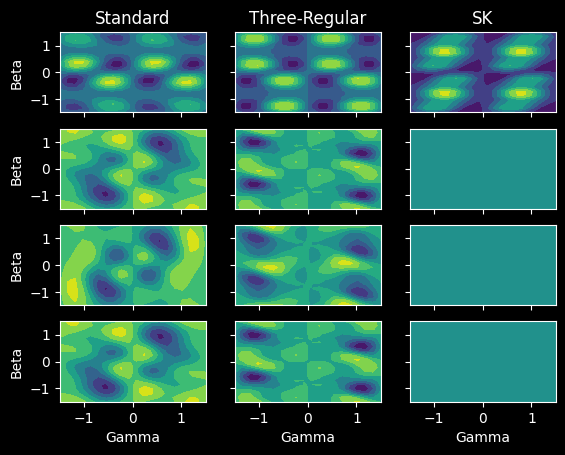

In [62]:
shots = 2048
backendStr = 'fakeManil'#'qasm_simulator'
problems = ["Standard", "Three-Regular", "SK"]
mixers = ["x_mixer", "xy_mixer_ring", "xy_mixer_parity", "xy_mixer_full"]

# Define the range of gamma and beta values
gamma_values = np.linspace(-1.5, 1.5, 20)
beta_values = np.linspace(-1.5, 1.5, 20)

# Create the contour plot
fig, axs = plt.subplots(4,3, sharex = True, sharey = True)

for i in range(len(mixers)):
    print(i)
    axs[i,0].set_ylabel('Beta')
    for j in range(len(problems)):
        values = get_function_values(gamma_values, beta_values, problems[j], mixers[i], backendStr, shots)
        axs[i,j].contourf(gamma_values, beta_values, values)
        axs[i,j].set_adjustable("box")
        #fig.colorbar(cs, label='Function value', ax=axs[0,2])
for i in range(len(problems)):
    axs[0,i].set_title(problems[i])
    axs[len(mixers)-1, i].set_xlabel('Gamma')
    
plt.show()